## Power for pcqtls
are pcqtls (especially pc1qtls) boosting power to detect signals that exist in signle egene analysis, but just are below detection thresholds?

Looking at the set of pcqtls that don't overlap with eqtls, then ask if the nominal p value distribution for the eqtls is enriched for low p values

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.auto import tqdm  # for notebooks
import scipy.stats as stats

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

### load in data
nominal p values and overlap dfs

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
eqtl_output_dir = config['eqtl_output_dir']
pcqtl_output_dir = config['pcqtl_output_dir']
overlap_output_dir = config['overlap_output_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type


### credible set sizes

In [3]:
overlap_df = load_overlap(config, tissue_id)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ttest_indResult(statistic=-1.2041803113529235, pvalue=0.22860181300330928)


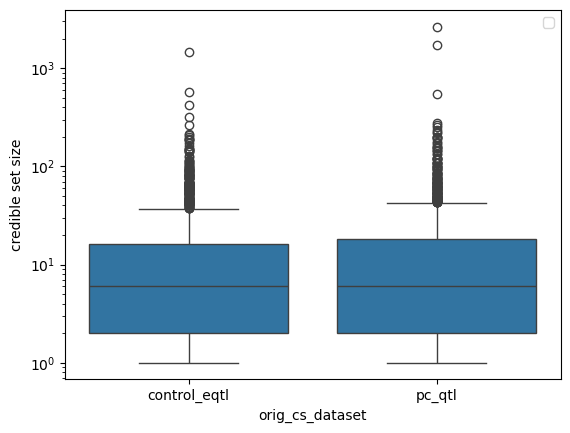

In [24]:
# credible set sizes pcqtl vs eqtl
overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl']['cs_size']

fig, ax = plt.subplots()
sns.boxplot(overlap_df, x='orig_cs_dataset', y='cs_size', ax=ax)
ax.set_ylabel('credible set size')
ax.set_yscale('log')

print(stats.ttest_ind(overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl']['cs_size'], overlap_df[overlap_df['orig_cs_dataset']=='pc_qtl']['cs_size']))
plt.legend()

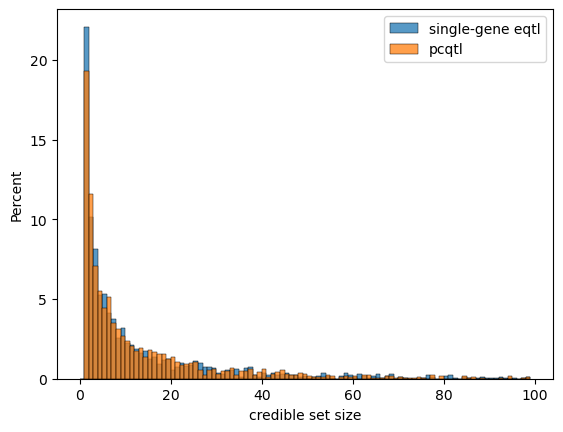

In [5]:
# credible set sizes pcqtl vs eqtl
fig, ax = plt.subplots()
sns.histplot(overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl']['variant_list'].str.split(',').apply(len), bins=range(0, 100), ax=ax, label='single-gene eqtl', stat='percent')
sns.histplot(overlap_df[overlap_df['orig_cs_dataset']=='pc_qtl']['variant_list'].str.split(',').apply(len), bins=range(0, 100), ax=ax, label='pcqtl', stat='percent')
ax.set_xlabel('credible set size')

plt.legend()

In [7]:
# look at p values in non overlaping part
e_nominal = load_e_nominal_all_chr(config, tissue_id)
pc_nominal = load_pc_nominal_all_chr(config, tissue_id)

In [67]:
overlap_df['cluster_variant'] = overlap_df['cluster_id'].astype(str) + '_' + overlap_df['lead_variant_id'].astype(str)
e_nominal['cluster_variant'] = e_nominal['cluster_id'].astype(str) + '_' + e_nominal['variant_id'].astype(str)
pc_nominal['cluster_variant'] = pc_nominal['cluster_id'].astype(str) + '_' + pc_nominal['variant_id'].astype(str)

In [68]:
pc_only_vars = overlap_df[overlap_df['num_pc_overlap'] == 0]['cluster_variant']
e_only_vars = overlap_df[overlap_df['num_e_overlap'] == 0]['cluster_variant']

pc_only_e_pvalues = e_nominal[e_nominal['cluster_variant'].isin(pc_only_vars)]['pval_nominal']
e_only_pc_pvalues = e_nominal[e_nominal['cluster_variant'].isin(e_only_vars)]['pval_nominal']

In [69]:
joint_nominal_lead_vars = pd.DataFrame(pd.concat([pc_only_e_pvalues, e_only_pc_pvalues], keys=['pc_only', 'e_only'], names=['type', 'idx']))

<AxesSubplot: xlabel='pval_nominal', ylabel='Percent'>

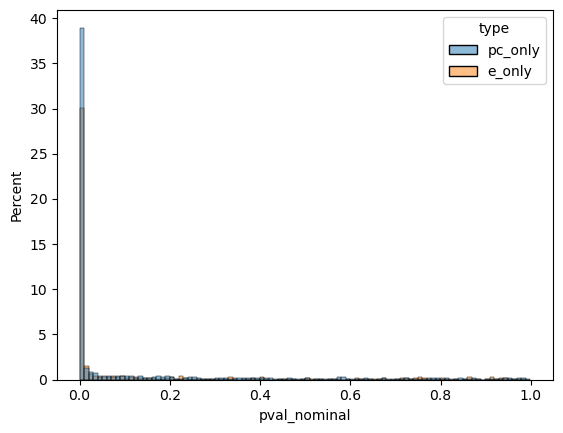

In [70]:
sns.histplot(joint_nominal_lead_vars, x='pval_nominal', bins=100, hue='type', stat='percent')

## old stuff

In [3]:
# load in the overlap df so we can pull credible sets that are pcqtls not eqtls
overlap_df = load_overlap(config, tissue_id)

# label cluster-variant pairs
overlap_df['var_cluster'] = overlap_df['lead_variant_id'] + '_' + overlap_df['cluster_id']

# add some info to the overlap cluster
overlap_df['pc_num'] = np.where(overlap_df['orig_cs_dataset']=='pc_qtl',  overlap_df['cs_full_id'].str.split('_').str[-2].str.strip('pc'), 0)
overlap_df['pc_num'] = overlap_df['pc_num'].astype(int)
# add in cluster size
overlap_df['cluster_size'] = overlap_df['cluster_id'].str.split('_').apply(len)


In [34]:
# load nominal p value dfs

def var_pos(df):
    return df['variant_id'].str.split('_').str[1].astype(int)

# load in e nominal
def load_e_nominal(path):
    e_nominal_df = pd.read_parquet(path)
    #e_nominal_df['variant_pos'] = var_pos(e_nominal_df)
    e_nominal_df['cluster_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[0]
    #e_nominal_df['egene_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[1]
    return e_nominal_df

e_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    e_nominal_dfs.append(load_e_nominal(f'{prefix}/{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet'))

e_nominal_df = pd.concat(e_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

In [35]:
def load_pc_nominal(path):
    pc_nominal_df = pd.read_parquet(path)
    #pc_nominal_df['variant_pos'] = var_pos(pc_nominal_df)
    pc_nominal_df['cluster_id'] = pc_nominal_df['phenotype_id'].str[:-4]
    #pc_nominal_df['cluster_size'] = pc_nominal_df['phenotype_id'].str.split('_').str.len() - 1
    return pc_nominal_df

pc_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    pc_nominal_dfs.append(load_pc_nominal(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.cis_qtl_pairs.chr{chr_id}.parquet'))
pc_nominal_df = pd.concat(pc_nominal_dfs)


  0%|          | 0/22 [00:00<?, ?it/s]

In [36]:
# write out? This was taking forever, so skiiping for now. It's ~ 6 minutes to load in data 

#e_nominal_df.to_csv(f'{e_out_prefix}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.csv.gz', sep='\t', compression='gzip')
#pc1_nominal_df.to_csv(f'{pc_out_prefix}/{tissue_id}.v8.pc_1.cis_qtl_pairs.csv.gz', sep='\t', compression='gzip')
#pc2_nominal_df.to_csv(f'{pc_out_prefix}/{tissue_id}.v8.pc_2.cis_qtl_pairs.csv.gz', sep='\t', compression='gzip')

In [38]:
# var cluster pairs to the nominal dfs
pc_nominal_df['var_cluster'] = pc_nominal_df['variant_id'] + '_' + pc_nominal_df['cluster_id']
e_nominal_df['var_cluster'] = e_nominal_df['variant_id'] + '_' + e_nominal_df['cluster_id']


# add some info to the pc nominal df
pc_nominal_df['pc_num'] = pc_nominal_df['phenotype_id'].str.split('_pc').str[-1]

## nominal p value distribution

In [39]:
def plot_nominal_ps(exclusive_df, min_e_per_cluster=False, same_pc_num=None, min_pc_per_cluster=False):
    fig, ax = plt.subplots(figsize=(8, 6))

    # plot a null on on the axis
    sns.histplot(np.arange(0,1,.001), bins=np.arange(0,1,.001), 
                 stat='density', element='step', fill=False,cumulative=True, 
                 label='null', ax=ax, color='k', linestyle='--')


    # lead variants exclusive to pc1
    pc_nominal_ps = pc_nominal_df[pc_nominal_df['var_cluster'].isin(exclusive_df['var_cluster'])]
    e_nominal_ps = e_nominal_df[e_nominal_df['var_cluster'].isin(exclusive_df['var_cluster'])]

    # plot the minimum egene p value per cluster
    if min_e_per_cluster:
        e_min_nominal_ps = e_nominal_ps.loc[e_nominal_ps.groupby('cluster_id')['pval_nominal'].idxmin()]
        sns.histplot(e_min_nominal_ps['pval_nominal'], bins=np.arange(0,1,.001), 
                     stat='density', element='step', fill=False,cumulative=True, 
                     label='min e', ax=ax, color='#016895')

    # plot the minimum egene p value per cluster
    if min_pc_per_cluster:
        pc_min_nominal_ps = pc_nominal_ps.loc[pc_nominal_ps.groupby('cluster_id')['pval_nominal'].idxmin()]
        sns.histplot(pc_min_nominal_ps['pval_nominal'], bins=np.arange(0,1,.001), 
                     stat='density', element='step', fill=False,cumulative=True, 
                     label='min pc', ax=ax, color='#820000')


    # plot the pc that matches the pc number if given 
    if same_pc_num != None:
        same_pc_nominal_ps = pc_nominal_df[pc_nominal_df['var_cluster'].isin(exclusive_df[exclusive_df['pc_num'] == same_pc_num]['var_cluster'])]
        sns.histplot(same_pc_nominal_ps['pval_nominal'], bins=np.arange(0,1,.001), 
                     stat='density', element='step', fill=False,cumulative=True, 
                     label='same pc', ax=ax, color='#E98300' if min_pc_per_cluster else '#820000')


    # make the cumiulative plots for all es and pcs
    sns.histplot(e_nominal_ps['pval_nominal'], bins=np.arange(0,1,.001), 
                 stat='density', element='step', fill=False,cumulative=True, 
                 label='e', ax=ax, color='#67AFD2')
    sns.histplot(pc_nominal_ps['pval_nominal'], bins=np.arange(0,1,.001), 
                 stat='density', element='step', fill=False,cumulative=True, 
                 label='pc', ax=ax, color='#B83A4B')


    ax.set_ylabel('Cumulative density')
    ax.set_xlabel('Nominal p value')
    ax.legend()
    return ax


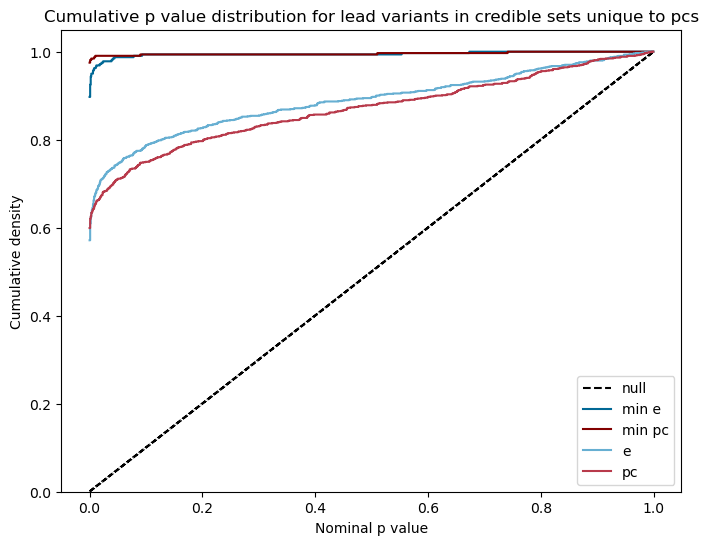

In [40]:

ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['orig_cs_dataset']=='pc_qtl')], min_pc_per_cluster=True, min_e_per_cluster=True)
ax.set_title('Cumulative p value distribution for lead variants in credible sets unique to pcs')
plt.show()


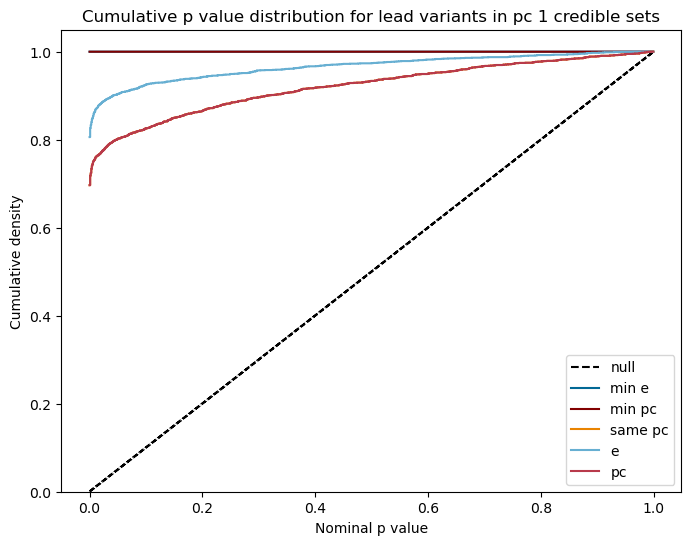

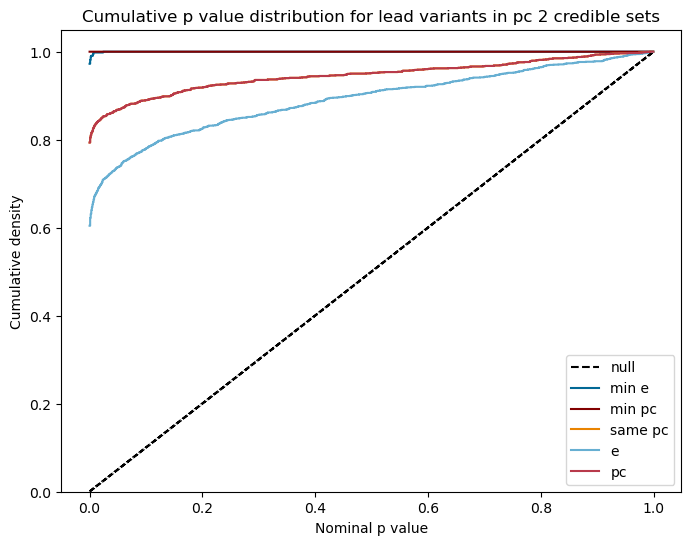

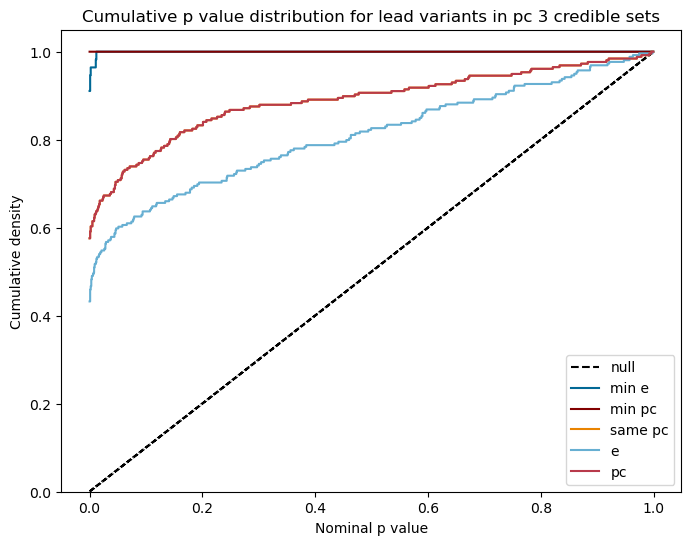

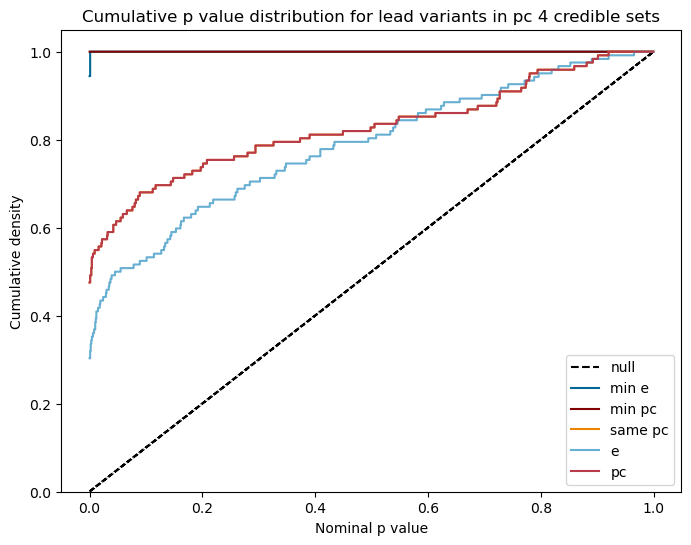

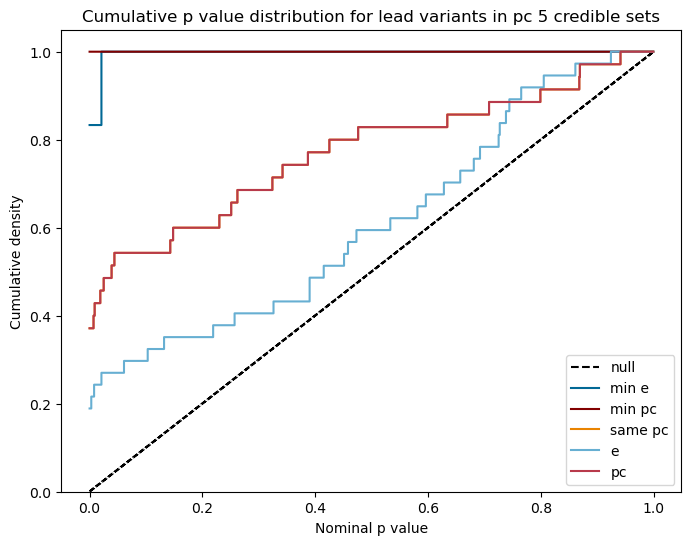

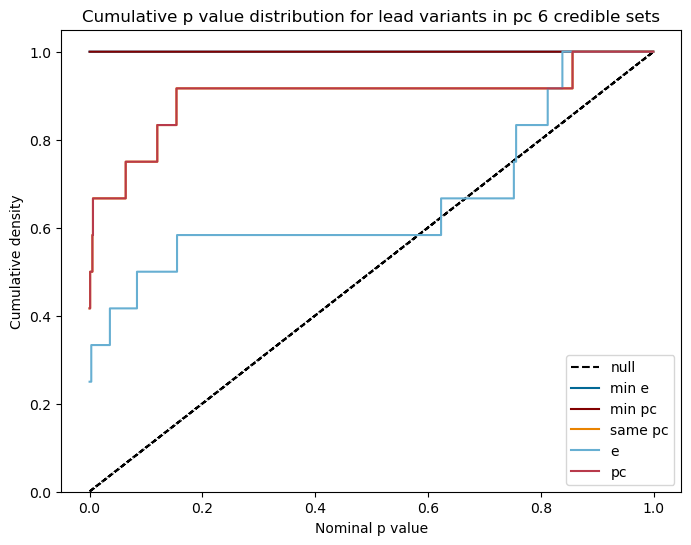

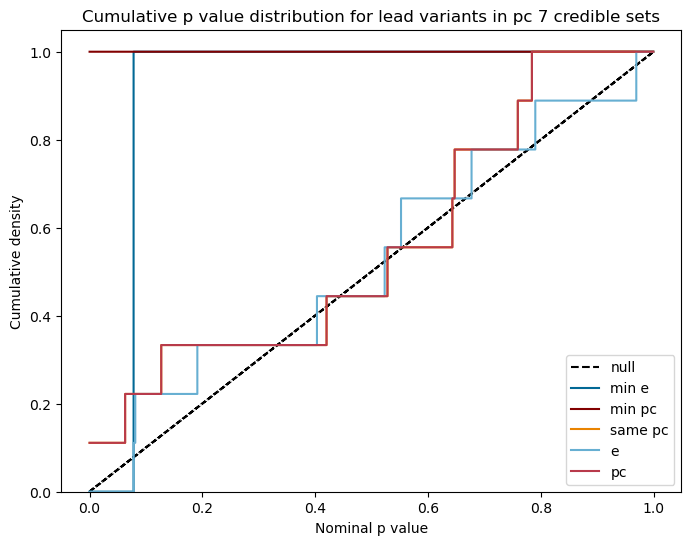

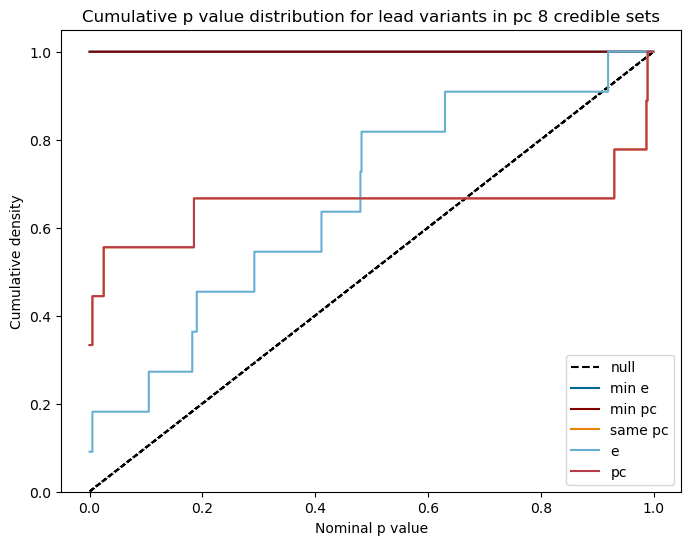

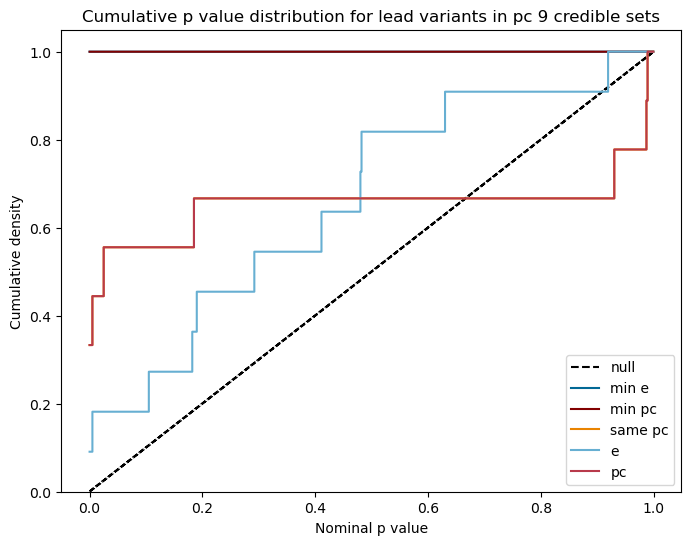

In [45]:
# specifc pc numbers

for i in range(overlap_df['pc_num'].max()):
    ax = plot_nominal_ps(overlap_df[(overlap_df['orig_cs_dataset']=='pc_qtl')&(overlap_df['pc_num']==i+1)],min_pc_per_cluster=True, min_e_per_cluster=True, same_pc_num=i+1)
    ax.set_title(f'Cumulative p value distribution for lead variants in pc {i+1} credible sets')
    plt.show()

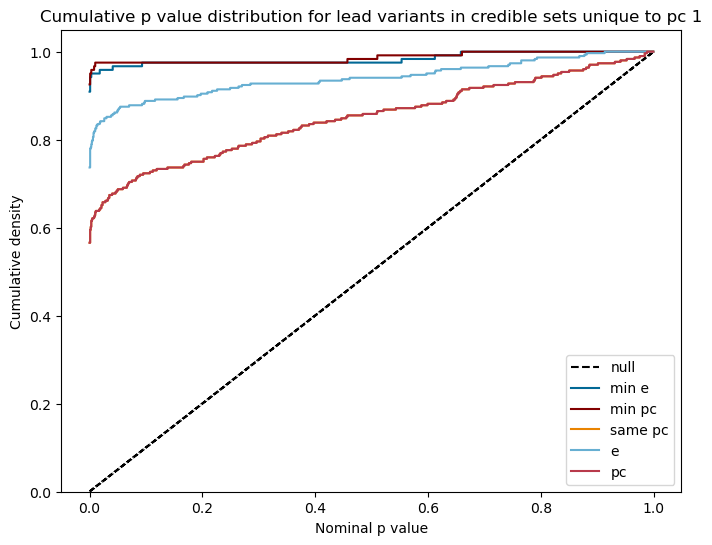

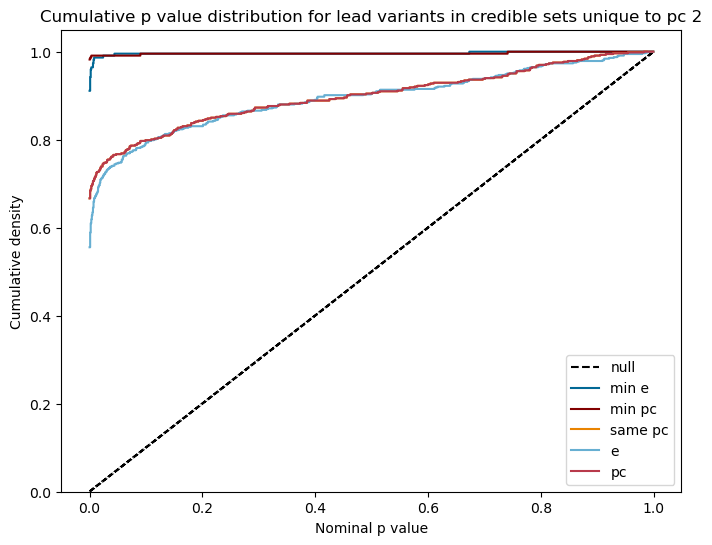

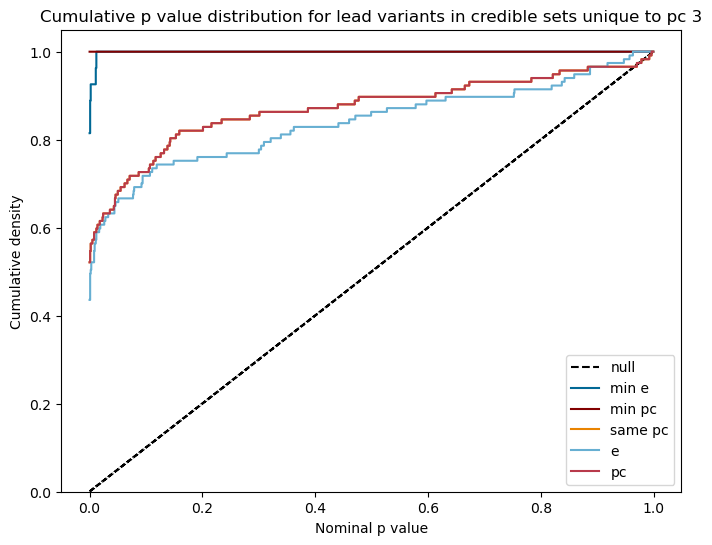

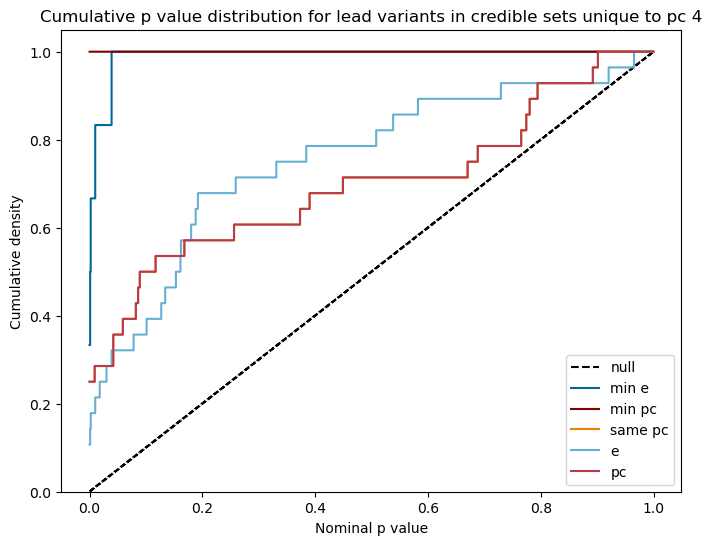

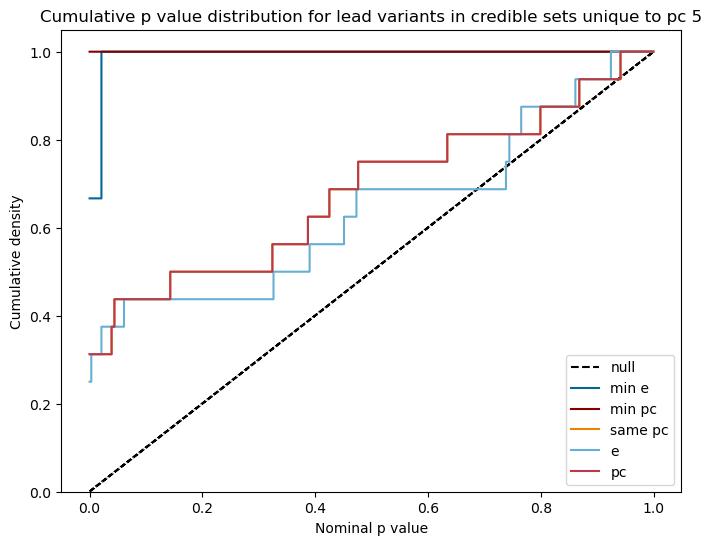

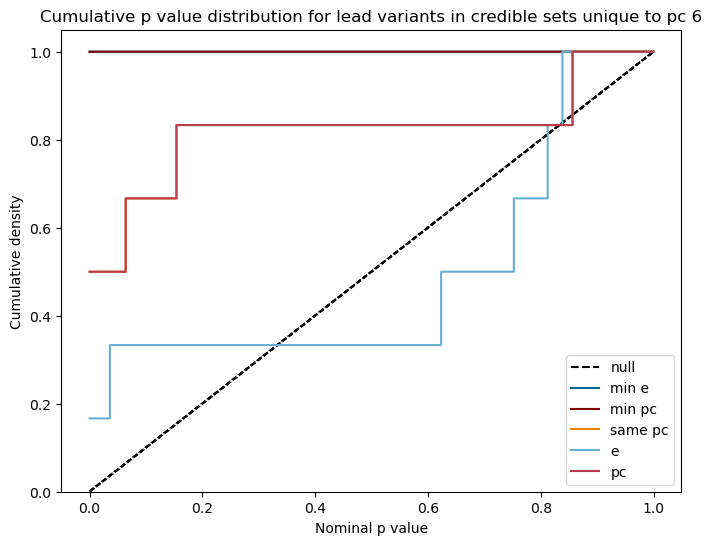

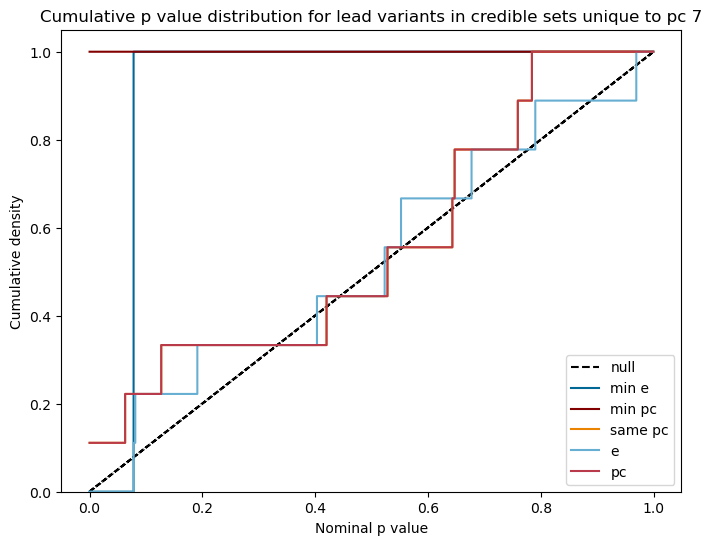

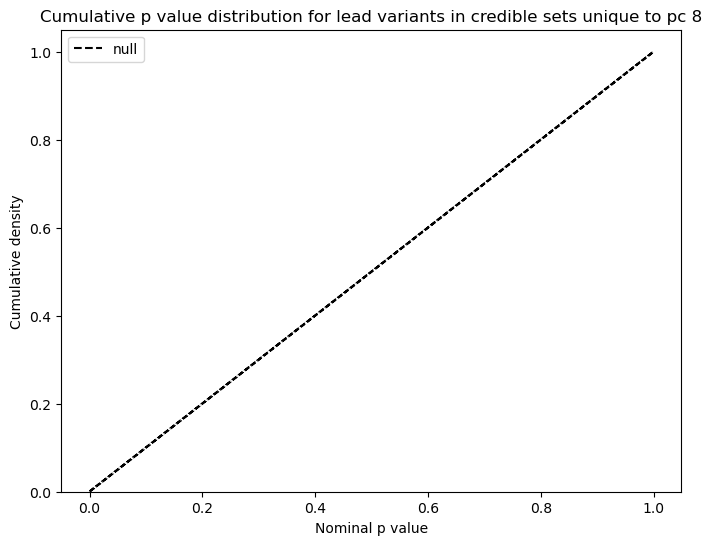

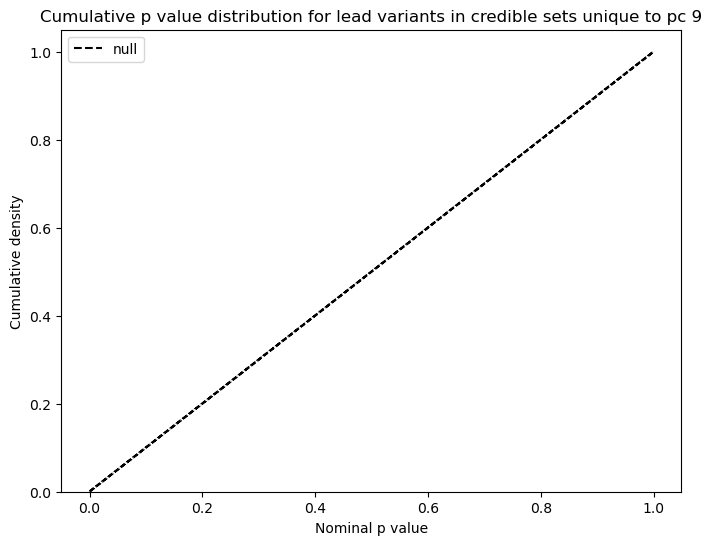

In [46]:
# unique to specifc pc numbers

for i in range(overlap_df['pc_num'].max()):
    ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['orig_cs_dataset']=='pc_qtl')&(overlap_df['pc_num']==i+1)],min_pc_per_cluster=True, min_e_per_cluster=True, same_pc_num=i+1)
    ax.set_title(f'Cumulative p value distribution for lead variants in credible sets unique to pc {i+1}')
    plt.show()


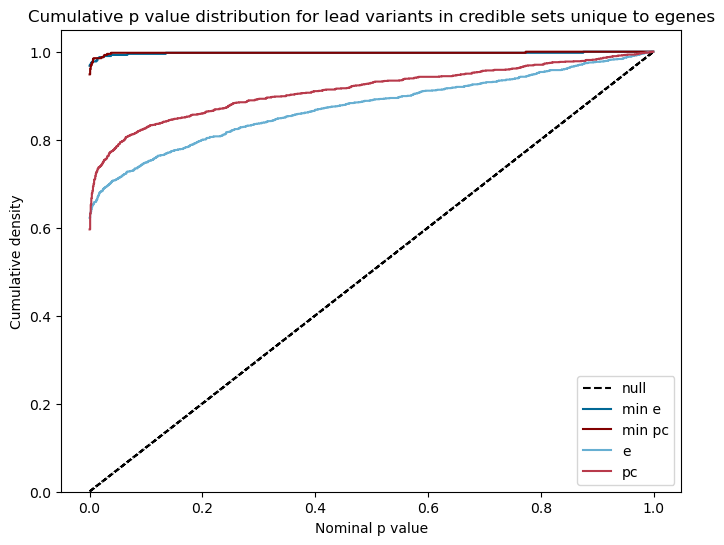

In [47]:
# lead variants exclusive to eqtls

ax = plot_nominal_ps(overlap_df[(overlap_df['num_pc_overlap']==0)&(overlap_df['orig_cs_dataset']=='control_eqtl')], min_pc_per_cluster=True, min_e_per_cluster=True)
ax.set_title('Cumulative p value distribution for lead variants in credible sets unique to egenes')
plt.show()


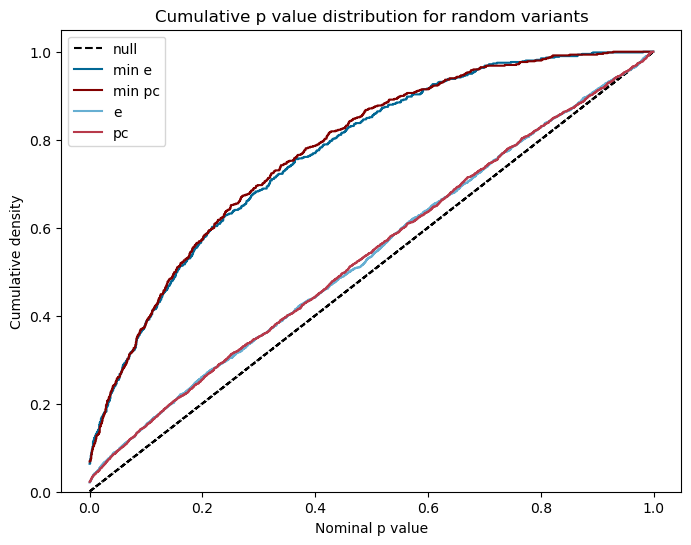

In [49]:
# against random selection of variants
random = pc_nominal_df.sample(1000)

ax = plot_nominal_ps(random, min_pc_per_cluster=True, min_e_per_cluster=True)
ax.set_title('Cumulative p value distribution for random variants')
plt.show()


## expression of pcqtl genes

maybe pcqtl genes are mroe lowly expressed, and so the power boost from considering multiple genes together is needed

In [4]:
# load in expression data 
# filtered_expression_output_dir is normalized, I need the pre-normed expression 

expression_dir = config['expression_dir']
# load in gene expression data
expression_df = ç
# add a cluster id and pc number column
expression_df['cluster_id'] = expression_df['gene_id'].str.split('_e_').str[0]
expression_df['egene_id'] = expression_df['gene_id'].str.split('_e_').str[1]

sample_ids = expression_df.columns[4:-2]

# average expression (is this normalized?)
expression_df['avg_expression'] = expression_df[sample_ids].mean(axis=1)
expression_df['median_expression'] = expression_df[sample_ids].median(axis=1)

expression_df.set_index('gene_id', inplace=True)

expression_df.head()

,#chr,start,end,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,...,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,cluster_id,egene_id,avg_expression,median_expression
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000227232.5,chr1,29552,29553,-1.175813,-0.617068,-1.648873,-0.409983,0.892918,0.432622,0.472789,...,-0.832798,0.579898,-0.393142,-0.015538,-1.712650,-0.387553,ENSG00000227232.5,NaN,-6.849823e-17,0.0
ENSG00000241860.6,chr1,173861,173862,1.629034,0.166494,-1.505361,0.537519,0.135063,-0.854980,1.125610,...,-0.818235,0.940215,-1.609816,0.129838,0.789616,0.299626,ENSG00000241860.6,NaN,1.480191e-03,0.0
ENSG00000279457.4,chr1,195410,195411,-0.182269,-2.083671,-1.240269,-0.870005,-1.322654,-0.579898,-0.161245,...,0.245867,-0.208664,-1.360873,-1.629034,-0.072569,0.415623,ENSG00000279457.4,NaN,-7.504924e-17,0.0
ENSG00000228463.9,chr1,297501,297502,-2.500646,-0.387553,-1.145345,-1.262938,-0.432622,-0.261913,-0.761630,...,0.432622,-0.208664,-0.714033,-1.609816,-1.286275,1.196748,ENSG00000228463.9,NaN,4.503394e-04,0.0
ENSG00000237094.11,chr1,501616,501617,-0.156000,1.024106,-1.896823,-0.573781,0.421276,1.759383,0.543513,...,1.096804,-0.272648,-1.106304,0.478588,-0.885229,0.376411,ENSG00000237094.11,NaN,3.071902e-04,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

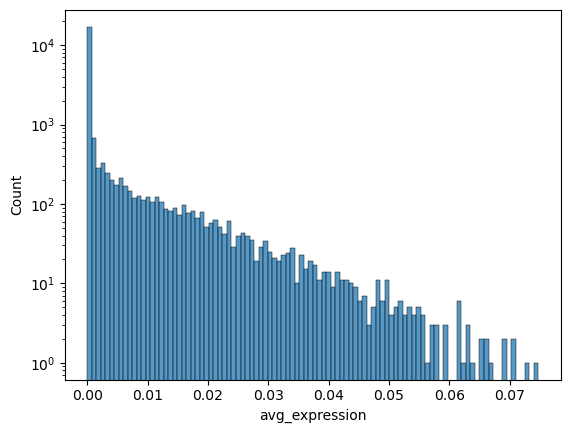

In [5]:
# distribution of averages
ax = sns.histplot(expression_df, x='avg_expression', bins=100)
ax.set_yscale('log')
plt.show

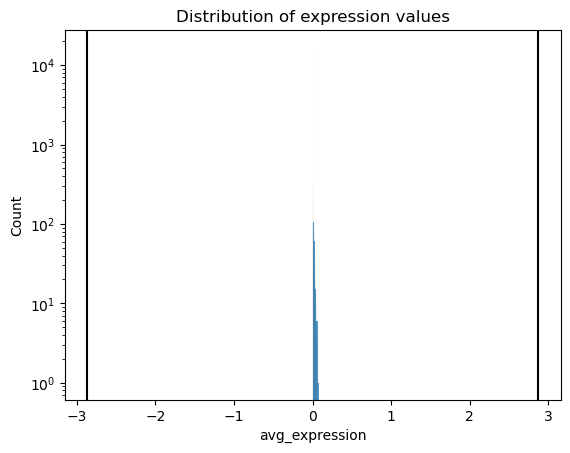

In [6]:
fig, ax = plt.subplots()

ax.set_title('Distribution of expression values')
# lines for largest and smallest values in the dataset
# trying to get at if the is too normalized to be useful
ax.axvline(expression_df[sample_ids].min().min(), label='smallest expression value', color='k')
ax.axvline(expression_df[sample_ids].max().max(), label='largest expression value', color='k')


# distribution of averages
sns.histplot(expression_df, x='avg_expression', bins=100, ax=ax)
ax.set_yscale('log')
plt.show()

seems like a slightly more squashed distribution that I would expect, but I'll go ahead and try it

In [7]:
# clusters with eqtl or pcqtl only
grouped_cluster_df = overlap_df.groupby('cluster_id').agg({
    'orig_cs_dataset':list
})

# there are not many clusters that only have pcqtl signals, more have only eqtl signals
pc_exclusive_clusters = grouped_cluster_df[~grouped_cluster_df['orig_cs_dataset'].astype(str).str.contains('control_eqtl')].index.values
e_exclusive_clusters = grouped_cluster_df[~grouped_cluster_df['orig_cs_dataset'].astype(str).str.contains('pcqtl')].index.values

print(len(pc_exclusive_clusters))
print(len(e_exclusive_clusters))

25
837


<AxesSubplot: xlabel='cluster_size', ylabel='Percent'>

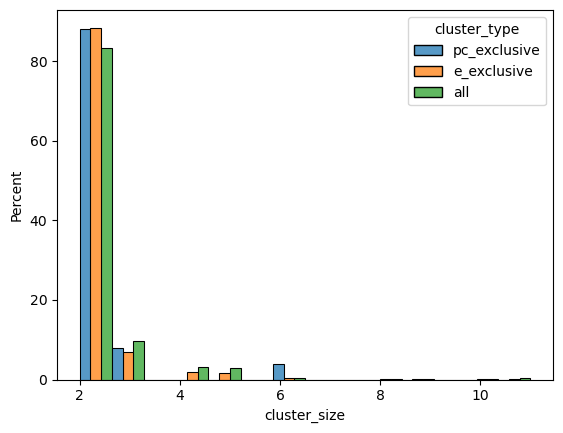

In [8]:
# do they differ in cluster size distribution

pc_exclusive_cluster_size = [len(cluster.split('_')) for cluster in pc_exclusive_clusters]
e_exclusive_cluster_size = [len(cluster.split('_')) for cluster in e_exclusive_clusters]

# combine into one df
joined_df = pd.DataFrame(pd.concat([pd.Series(pc_exclusive_cluster_size, name='cluster_size'), pd.Series(e_exclusive_cluster_size, name='cluster_size'), overlap_df['cluster_size']], 
                                   keys=['pc_exclusive', 'e_exclusive', 'all'], names=['cluster_type']))

# plot
sns.histplot(joined_df, x='cluster_size', hue='cluster_type', stat='percent', common_norm=False, multiple='dodge')

In [9]:
# do they differ in average gene expression distribution
pc_exclusive_genes = '_'.join(pc_exclusive_clusters).split('_')
e_exclusive_genes = '_'.join(e_exclusive_clusters).split('_')
cluster_genes = '_'.join(overlap_df['cluster_id']).split('_')

# drop duplicates
pc_exclusive_genes = pd.Series(pc_exclusive_genes).drop_duplicates()
e_exclusive_genes = pd.Series(e_exclusive_genes).drop_duplicates()
cluster_genes = pd.Series(cluster_genes).drop_duplicates()

In [10]:
expression_df.loc[pc_exclusive_genes]['avg_expression']

# combine into one df
joined_df = pd.DataFrame(pd.concat([expression_df.loc[pc_exclusive_genes]['avg_expression'], expression_df.loc[e_exclusive_genes]['avg_expression'], expression_df.loc[cluster_genes]['avg_expression']], 
                                   keys=['pc_exclusive', 'e_exclusive', 'all'], names=['cluster_type']))


In [11]:
joined_df

avg_expression
cluster_type gene_id                           
pc_exclusive ENSG00000006016.10   -4.045533e-17
             ENSG00000105696.8     1.241243e-17
             ENSG00000167487.11    6.895795e-18
             ENSG00000037965.5     8.596758e-17
             ENSG00000123388.4     4.183449e-17
...                                         ...
all          ENSG00000196890.4     4.503394e-04
             ENSG00000185634.11   -2.298598e-18
             ENSG00000255302.4    -1.218257e-17
             ENSG00000204388.6     1.672230e-17
             ENSG00000204389.9     5.855679e-17

[3696 rows x 1 columns]

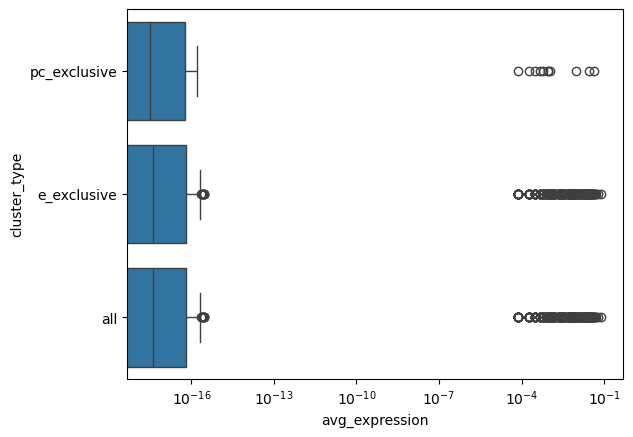

In [18]:
ax = sns.boxplot(joined_df, x='avg_expression', y='cluster_type')
ax.set_xscale('log')